In [29]:
%matplotlib inline
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from config import Config
import utils
import model as modellib
import visualize
from model import log
import skimage.io
import skimage.transform
from scipy.ndimage.morphology import  binary_fill_holes
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR,"mask_rcnn_coco.h5")

In [3]:
class databowlConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the databowl shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "databowl"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 3
    IMAGES_PER_GPU = 1
    
    RPN_NMS_THRESHOLD = 0.7

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    TRAIN_ROIS_PER_IMAGE = 500
    
    MEAN_PIXEL = np.array([0, 0, 0])

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    USE_MINI_MASK = True
    
    MAX_GT_INSTANCES = 500
    
    LEARNING_RATE = 0.01



    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 670 // (IMAGES_PER_GPU * GPU_COUNT) 

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 119 // (IMAGES_PER_GPU * GPU_COUNT) 
    
config = databowlConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      3
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               500
MEAN_PIXEL                     [0 0 0]
MINI_MASK_SHAPE                (56, 56)
NAME                           databowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
R

In [4]:
def watershed_algorithm(mask):
    #find distance between pixels and backgrounds
    distance = ndimage.distance_transform_edt(mask)
    #find local max
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)), labels=mask)
    
    markers = ndimage.label(local_maxi)[0]
    
    labels = watershed(-distance, markers, mask=mask)
    
    return labels
def is_valid_bbox(mask):
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    if horizontal_indicies.shape[0]:
        x1, x2 = horizontal_indicies[[0, -1]]
        y1, y2 = vertical_indicies[[0, -1]]
        x2 += 1
        y2 += 1
    else:
        x1, x2, y1, y2 = 0, 0, 0, 0
    mask = mask[y1:y2, x1:x2]
    if mask.size == 0:
        return False
    else:
        return True
    
def load_mask(self, image_id):
    image_info = self.image_info[image_id]
    mask_path = os.path.join(('/').join(image_info['path'].split('/')[:-2]), 'masks/')
    mask_ids = os.listdir(mask_path)     
    mask_shape = skimage.io.imread(os.path.join(mask_path,mask_ids[0])).shape
    #mask = np.zeros((mask_shape[0], mask_shape[1], len(mask_ids)))
    masks =[]
    for i in range(len(mask_ids)):
        img  = skimage.io.imread(os.path.join(mask_path,mask_ids[i]))
        #fill holes
        img = binary_fill_holes(img, structure = np.ones((2,2)))
        #try image segmentation
        img = watershed_algorithm(img)
        if(len(np.unique(img)) <=2):
            if (len(np.unique(img)) != 1) and (is_valid_bbox(img)):
                masks.append(img)
        else:
            for j in range(2,len(np.unique(img))):
                value = np.where(img==np.unique(img)[j], 1, 0)
                if is_valid_bbox(value):
                    masks.append(value)
    mask = np.zeros((masks[0].shape[0],masks[0].shape[1], len(masks)), dtype=np.int8)
    for i,img in enumerate(masks):     
        mask[:,:,i] = np.maximum(img, mask[:,:,i])
    class_ids = np.ones(shape=len(masks), dtype=np.int8)      
    return mask, class_ids

In [5]:
class DataBowlDataset(utils.Dataset):
    
    def load_databowl(self, datadir):
        
        #Add Classes
        self.add_class("databowl", 1, 'nucleus')
        
        #Add Images
        image_ids = os.listdir(datadir)
        
        for i in image_ids:
            self.add_image("databowl", image_id=i,
                path=os.path.join(datadir, i, 'images',str(i)+'.png'),
                width=256,
                height=256)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        
        image =image[:,:,:3]
        
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image
       
    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        mask_path = os.path.join(('/').join(image_info['path'].split('/')[:-2]), 'masks/')
        mask_ids = os.listdir(mask_path)     
        mask_shape = skimage.io.imread(os.path.join(mask_path,mask_ids[0])).shape
        mask = np.zeros((mask_shape[0], mask_shape[1], len(mask_ids)))
        for i in range(len(mask_ids)):
            img  = skimage.io.imread(os.path.join(mask_path,mask_ids[i]))
            #fill holes
            img = binary_fill_holes(img, structure = np.ones((2,2)))   
            mask[:,:,i] = np.maximum(img, mask[:,:,i])
        class_ids = np.ones(shape=len(mask_ids), dtype=np.int8)      
        return mask, class_ids
    
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "databowl":
            return info["databowl"]
        else:
            super(self.__class__).image_reference(self, image_id)        

In [6]:
train_path = 'dataset/stage1_train/'
dataset_train = DataBowlDataset()
dataset_train.load_databowl(train_path)
dataset_train.prepare()

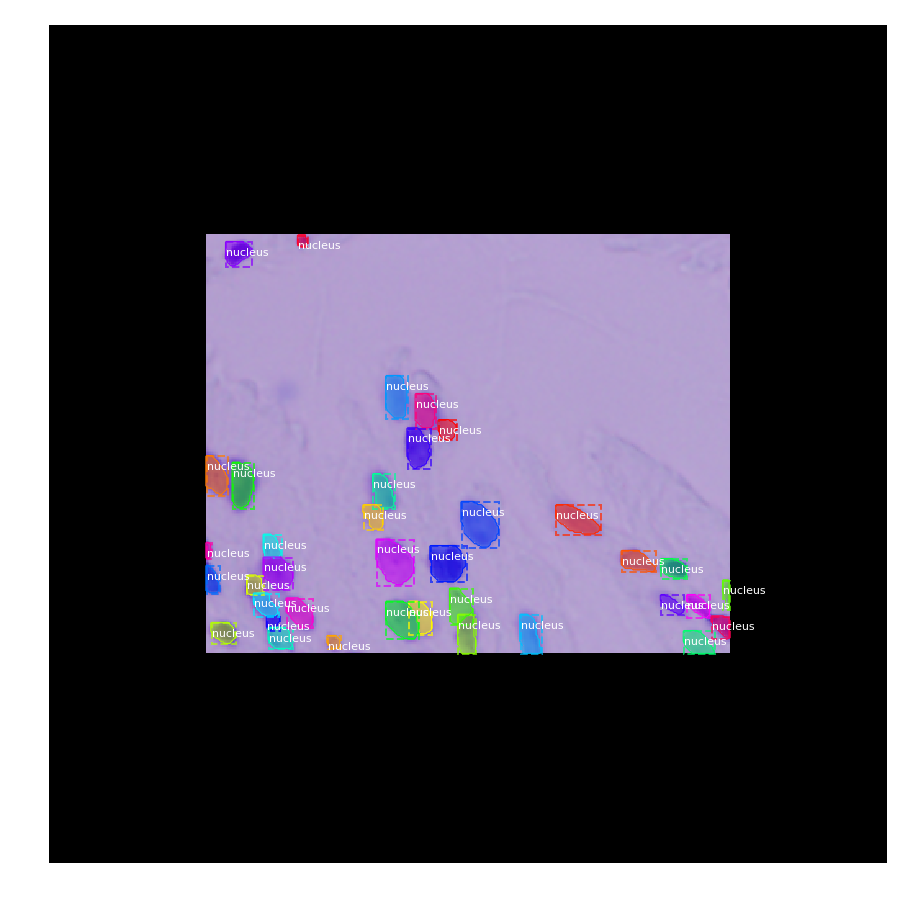

In [7]:
random_value = np.random.randint(len(dataset_train.image_ids))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_train, 
                                                                                  databowlConfig, random_value, 
                                                                                  use_mini_mask=False)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, ax=None)

In [8]:
valid_path = 'dataset/stage1_train_valid/'
dataset_valid = DataBowlDataset()
dataset_valid.load_databowl(valid_path)
dataset_valid.prepare()

In [32]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
weights = 'coco'

if weights == 'coco':
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

if weights == 'last':
    model.load_weights(model.find_last()[1], by_name=True)

In [11]:
model.train(dataset_train, dataset_valid,
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.01

Checkpoint Path: /home/user1/my_project/DL-Enthusiasts/logs/databowl20180216T2213/mask_rcnn_databowl_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/home/user1/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/user1/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


/home/user1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/user1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


223/223 [==============================] - 414s 2s/step - loss: 2.4997 - rpn_class_loss: 0.1633 - rpn_bbox_loss: 1.3807 - mrcnn_class_loss: 0.2137 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.3289 - val_loss: 1.9250 - val_rpn_class_loss: 0.0331 - val_rpn_bbox_loss: 1.2461 - val_mrcnn_class_loss: 0.1499 - val_mrcnn_bbox_loss: 0.2279 - val_mrcnn_mask_loss: 0.2682
Epoch 2/10
223/223 [==============================] - 448s 2s/step - loss: 1.9529 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 1.1275 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.2534 - mrcnn_mask_loss: 0.2826 - val_loss: 1.5647 - val_rpn_class_loss: 0.0257 - val_rpn_bbox_loss: 0.9026 - val_mrcnn_class_loss: 0.1448 - val_mrcnn_bbox_loss: 0.2274 - val_mrcnn_mask_loss: 0.2642
Epoch 3/10
223/223 [==============================] - 484s 2s/step - loss: 1.7596 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.9908 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2673 - val_loss: 1.4311 - val_rpn_class_loss: 0.0211

In [ ]:
model.train(dataset_train, dataset_valid, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, layers='all')


Starting at epoch 0. LR=0.01

Checkpoint Path: /home/user1/my_project/DL-Enthusiasts/logs/databowl20180217T0044/mask_rcnn_databowl_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

/home/user1/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/user1/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20


/home/user1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  9/223 [>.............................] - ETA: 6:22 - loss: 1.2103 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.3036

/home/user1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


223/223 [==============================] - 531s 2s/step - loss: 1.0332 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2544 - val_loss: 0.7640 - val_rpn_class_loss: 0.0325 - val_rpn_bbox_loss: 0.3431 - val_mrcnn_class_loss: 0.0582 - val_mrcnn_bbox_loss: 0.1211 - val_mrcnn_mask_loss: 0.2090
Epoch 2/20
223/223 [==============================] - 259s 1s/step - loss: 0.9946 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2465 - val_loss: 0.6779 - val_rpn_class_loss: 0.0205 - val_rpn_bbox_loss: 0.3003 - val_mrcnn_class_loss: 0.0306 - val_mrcnn_bbox_loss: 0.1064 - val_mrcnn_mask_loss: 0.2201
Epoch 3/20
223/223 [==============================] - 379s 2s/step - loss: 0.9650 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.2515 - val_loss: 0.7899 - val_rpn_class_loss: 0.0179

In [14]:
model.keras_model.save_weights('mask_rcnn_data.h5')

In [15]:
class InferenceConfig(databowlConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [16]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]
model_path = 'mask_rcnn_data.h5'

In [33]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  mask_rcnn_data.h5


In [33]:
image_id = random.choice(dataset_valid.image_ids)

In [34]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_valid, 
                                                                                  inference_config, image_id, 
                                                                                  use_mini_mask=False)

original_image           shape: (512, 512, 3)         min:    0.00000  max:  102.00000
image_meta               shape: (10,)                 min:    1.00000  max:  384.00000
gt_class_id              shape: (11,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (11, 4)               min:  128.00000  max:  384.00000
gt_mask                  shape: (512, 512, 11)        min:    0.00000  max:    1.00000


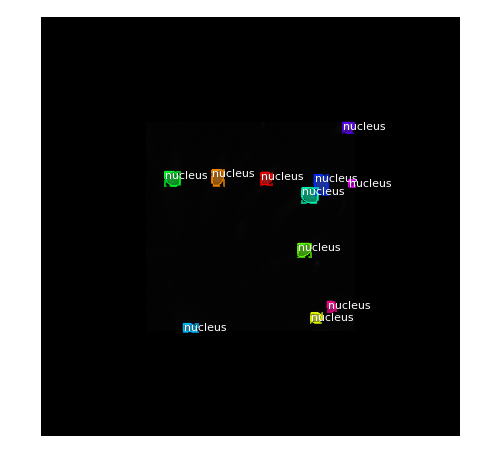

In [35]:
# Test on a random image


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [36]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  102.00000
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  102.00000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


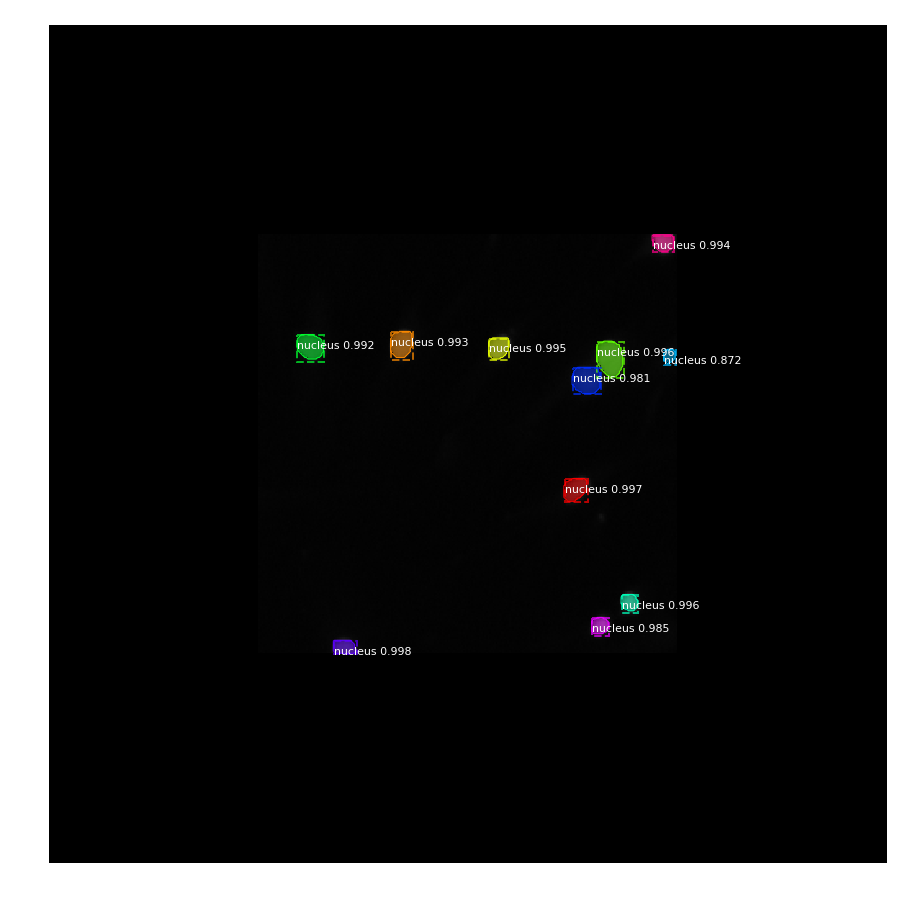

In [37]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_valid.class_names, r['scores'], ax=None)

In [20]:
from tqdm import tqdm_notebook

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_valid.image_ids, 10)
APs = []
for image_id in tqdm_notebook(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_valid, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))


mAP:  0.815298060662


In [21]:
dataset_test = DataBowlDataset()
dataset_test.load_databowl('dataset/stage1_test')
dataset_test.prepare()

In [22]:
#get result for masked image
mask_images = []
for image_id in tqdm_notebook(dataset_test.image_ids):
    image = dataset_test.load_image(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    mask_shape = r['masks'].shape
    mask_image = np.zeros((mask_shape[0], mask_shape[1]))
    for i in range(mask_shape[2]):
        mask_image[:,:] = np.where(r['masks'][:,:,i]==1, 1, mask_image[:,:]) 
    mask_images.append(mask_image)

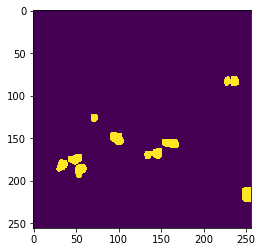

In [23]:
plt.imshow(mask_images[64])

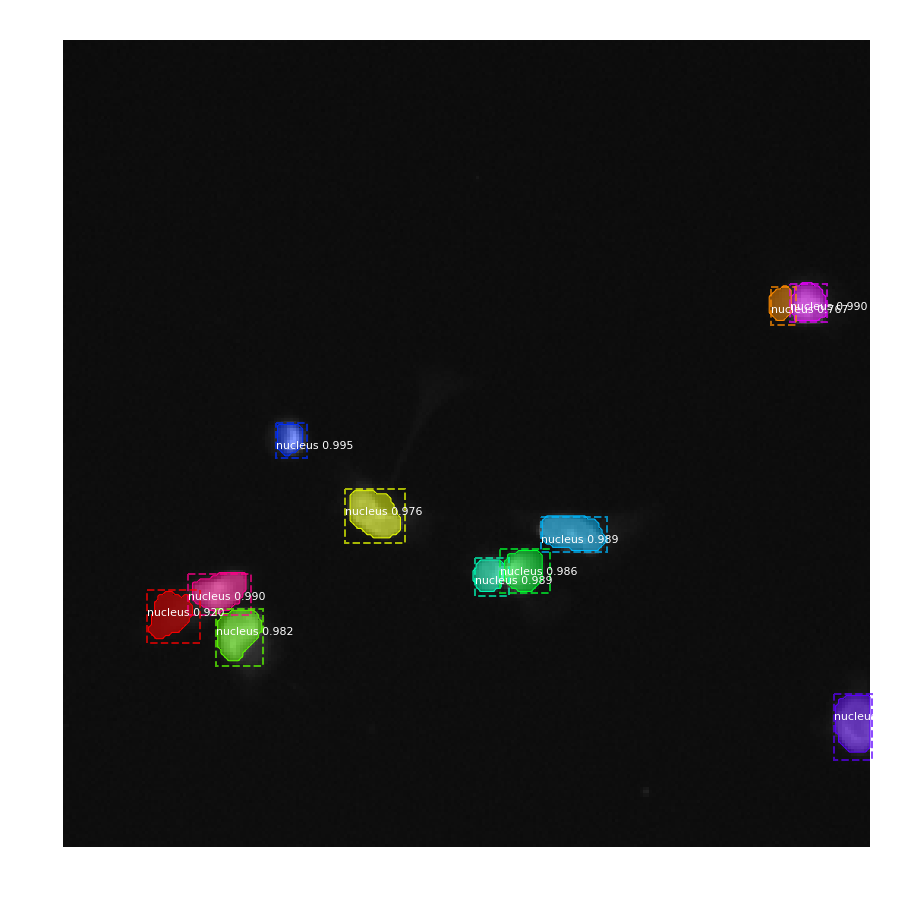

In [24]:
#Test of Images
image_idx = 64
original_image = dataset_test.load_image(dataset_test.image_ids[image_idx])
results = model.detect([original_image], verbose=0)
visualize.display_instances(original_image, results[0]['rois'], results[0]['masks'], results[0]['class_ids'], dataset_test.class_names, results[0]['scores'], ax=None)

In [25]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [26]:
new_test_ids = []
rles = []
for n, id_ in tqdm_notebook(enumerate(dataset_test.image_ids)):
    rle = list(prob_to_rles(mask_images[n]))
    #rle = list(rle_encoding(mask_images[n]))
    rles.extend(rle)
    new_test_ids.extend([dataset_test.image_info[n]['id']] * len(rle))

In [27]:
sub1 = pd.DataFrame({'ImageId':new_test_ids})
sub1['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x ))

In [28]:
sub1.to_csv('submission_new.csv', index=False)